# Import packages & Connect the database

In [0]:
# Install MYSQL client
pip install PyMySQL

In [0]:
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.22.1.


In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
import numpy as np
import pandas as pd
import datetime as dt

In [0]:
# Connect to database
import pymysql

conn = pymysql.connect(
    host='34.69.136.137',
    port=int(3306),
    user='root',
    passwd='rtfgvb77884',
    db='valenbisi',
    charset='utf8mb4')

# Prepare data

In [0]:
# Get Stations
df_station_snapshot = pd.read_sql_query("SELECT station_number, station_service_available, creation_date FROM station_snapshot WHERE station_number=31",
    conn)

In [0]:
def substractTime(x):
  date = dt.datetime(x.year, x.month, x.day, x.hour)
  return (date - dt.timedelta(hours=1))

def addTime(x):
  date = dt.datetime(x.year, x.month, x.day, x.hour)
  return (date + dt.timedelta(hours=1))

def getPrevAvailable(d_f, row):
  new_dateTime = substractTime(row['datetime'])
  try:
    return d_f[(d_f['id'] == row['id']) & (d_f['year'] == new_dateTime.year) & (d_f['month'] == new_dateTime.month) & (d_f['day'] == new_dateTime.day) & (d_f['hour'] == new_dateTime.hour)].iloc[0, d_f.columns.get_loc('available')]    
  except:
    return 0

def getNextAvailable(d_f, row):
  new_dateTime = addTime(row['datetime'])
  try:
    return d_f[(d_f['id'] == row['id']) & (d_f['year'] == new_dateTime.year) & (d_f['month'] == new_dateTime.month) & (d_f['day'] == new_dateTime.day) & (d_f['hour'] == new_dateTime.hour)].iloc[0, d_f.columns.get_loc('available')]    
  except:
    return 0

In [0]:
# Update titles
df_stations = df_station_snapshot.rename(index=str, columns={"station_number": "id", "station_service_available": "available", "creation_date": "datetime"})

df_stations['id'] = df_stations['id'].astype(str).astype(int);

# Transform date strinf to date without seconds
df_stations['datetime'] = pd.to_datetime(df_stations['datetime'], infer_datetime_format=True)
df_stations['datetime'] = df_stations['datetime'].dt.floor('H')

# # Sort by datetime
df_stations.sort_values(by=['datetime'], inplace=True, ascending=True)

# # Separate datetime in columns
df_stations['date'] = df_stations['datetime'].dt.date
df_stations['hour'] = df_stations['datetime'].dt.hour
df_stations['year'] = df_stations['datetime'].dt.year
df_stations['month'] = df_stations['datetime'].dt.month
df_stations['day'] = df_stations['datetime'].dt.day
df_stations['dayofweek'] = df_stations['datetime'].dt.dayofweek

# Group and avg by time
df_stations['available'] = df_stations.groupby(['id', 'date', 'hour'])['available'].transform('mean').astype(int)
df_stations.drop_duplicates(subset=['id', 'date', 'hour'], keep='first', inplace=True)

# # Set multiple avaiables
df_stations['available_prev'] = df_stations.apply(lambda x: getPrevAvailable(df_stations, x), axis=1)
df_stations['available_next'] = df_stations.apply(lambda x: getNextAvailable(df_stations, x), axis=1)

# # Clean columns
df_stations.drop(['datetime', 'day'], axis=1, inplace=True)

In [0]:
df_stations.tail()

,id,available,date,hour,year,month,dayofweek,available_prev,available_next
60560,31,16,2020-02-11,13,2020,2,1,16,17
81522,31,17,2020-02-11,14,2020,2,1,16,17
19544,31,17,2020-02-11,15,2020,2,1,17,16
84216,31,16,2020-02-11,16,2020,2,1,17,15
21903,31,15,2020-02-11,17,2020,2,1,16,0


In [0]:
# Get Holidays
df_holiday_snapshot = pd.read_sql_query("SELECT date, enabled FROM holiday",
    conn)

In [0]:
# Update titles
df_holiday = df_holiday_snapshot.rename(index=str, columns={"enabled": "holiday"})

# Sort by datetime
df_holiday.sort_values(by=['date'], inplace=True, ascending=True)

In [0]:
# Get Sport Events
df_event_snapshot = pd.read_sql_query("SELECT date, football, basketball FROM sport_event",
    conn)

In [0]:
# Clone data frame
df_event = df_event_snapshot

# Sort by datetime
df_event.sort_values(by=['date'], inplace=True, ascending=True)

In [0]:
# Get Weather
df_weather_snapshot = pd.read_sql_query("SELECT temperature, humidity, wind_speed, cloud_percentage, creation_date FROM weather",
    conn)

In [0]:
# Update titles
df_weather = df_weather_snapshot.rename(index=str, columns={"wind_speed": "wind", "cloud_percentage": "cloud", "creation_date": "datetime"})

# Transform date strinf to date without seconds
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'], infer_datetime_format=True)
df_weather['datetime'] = df_weather['datetime'].dt.floor('H')

# Separate datetime in two columns
df_weather['date'] = df_weather['datetime'].dt.date
df_weather['hour'] = df_weather['datetime'].dt.hour

# Group by datetime and get mean of the data
df_weather['temperature'] = df_weather.groupby(['hour', 'date'])['temperature'].transform('mean')
df_weather['humidity'] = df_weather.groupby(['hour', 'date'])['humidity'].transform('mean')
df_weather['wind'] = df_weather.groupby(['hour', 'date'])['wind'].transform('mean')
df_weather['cloud'] = df_weather.groupby(['hour', 'date'])['cloud'].transform('mean')

# Clean duplicated rows
df_weather.drop_duplicates(subset=['date', 'hour'], keep='first', inplace=True)

# Clean columns
df_weather.drop(['datetime'], axis=1, inplace=True)

In [0]:
# Merge stations with holidays
df = pd.merge(
    df_stations,
    df_holiday,
    how='left',
    left_on=['date'],
    right_on=['date']
)

# Replace NaN with 0
df['holiday'] = df['holiday'].fillna(0)

# Merge (stations with holidays) with sport events
df = pd.merge(
    df,
    df_event,
    how='left',
    left_on=['date'],
    right_on=['date']
)

# Replace NaN with 0
df['football'] = df['football'].fillna(0)
df['basketball'] = df['basketball'].fillna(0)

# Merge ((stations with holidays) with sport events) with weather
df = pd.merge(
    df,
    df_weather,
    how='left',
    left_on=['date', 'hour'],
    right_on=['date', 'hour']
)

# Replace NaN with 0
df['temperature'] = df['temperature'].fillna(0)
df['humidity'] = df['humidity'].fillna(0)
df['wind'] = df['wind'].fillna(0)
df['cloud'] = df['cloud'].fillna(0)

In [0]:
# Show latest data
print('DATA AGGREGATED FOR STATION: ' + station)
df.tail(10)

DATA AGGREGATED FOR STATION: 31


,available,date,hour,year,month,dayofweek,available_prev,available_next,holiday,football,basketball,temperature,humidity,wind,cloud
1472,7,2020-02-08,6,2020,2,5,7,7,0,0,0,6.185000,95.566667,1.293333,0.000000
1473,7,2020-02-08,7,2020,2,5,7,6,0,0,0,6.181833,93.000000,1.871667,10.666667
1474,6,2020-02-08,8,2020,2,5,7,4,0,0,0,7.779333,93.000000,1.560000,0.000000
1475,4,2020-02-08,9,2020,2,5,6,3,0,0,0,10.684167,87.400000,0.675333,0.000000
1476,3,2020-02-08,10,2020,2,5,4,7,0,0,0,13.145333,76.616667,1.265833,0.000000
1477,7,2020-02-08,11,2020,2,5,3,14,0,0,0,15.177167,61.266667,1.724000,2.000000
1478,14,2020-02-08,12,2020,2,5,7,10,0,0,0,15.971500,60.066667,0.600000,20.000000
1479,10,2020-02-08,13,2020,2,5,14,8,0,0,0,16.433667,56.333333,1.733333,20.000000
1480,8,2020-02-08,14,2020,2,5,10,10,0,0,0,16.451667,58.733333,2.933333,20.000000
1481,10,2020-02-08,15,2020,2,5,8,0,0,0,0,15.644151,65.490566,3.826415,20.000000


# Visualize the data

In [0]:
# Load libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns;

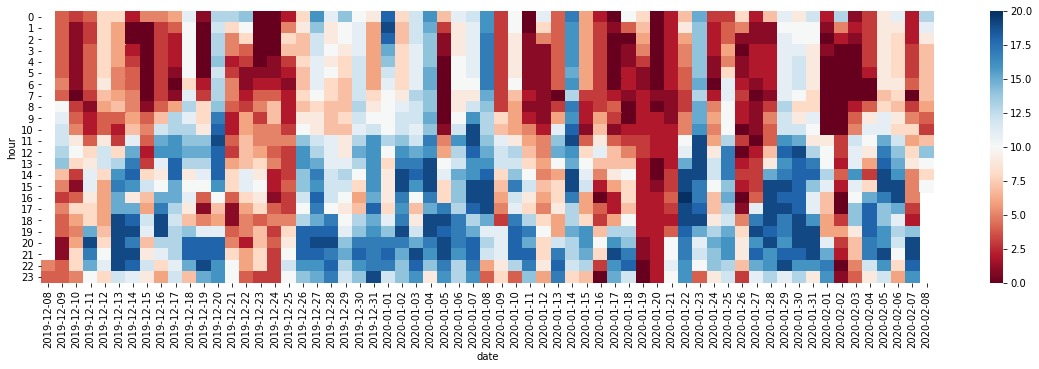

In [0]:
# HEATMAP CHART PER MIN (10)

heatmap_data = pd.pivot_table(df[df['id']==31], values='available', index='hour', columns='date')
fig, ax = plt.subplots(figsize=(20,5)) 
sns.heatmap(heatmap_data, cmap='RdBu', ax=ax)

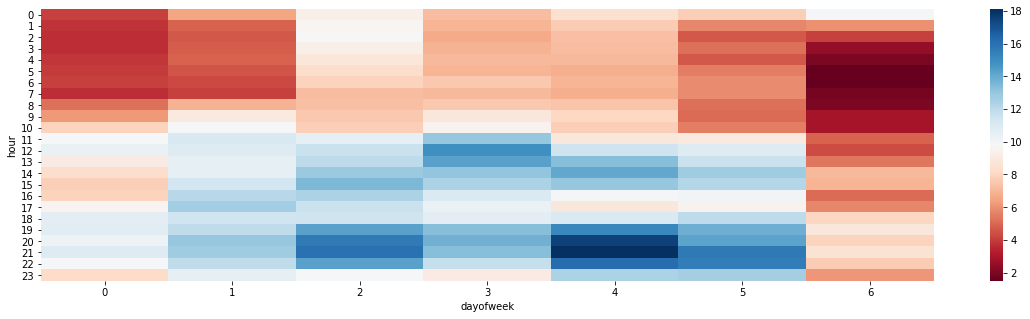

In [0]:
# HEATMAP CHART PER WEEK DAY

heatmap_data_week_day = pd.pivot_table(df[df['id']==31], values='available', index='hour', columns='dayofweek')
fig, ax = plt.subplots(figsize=(20,5)) 
sns.heatmap(heatmap_data_week_day, cmap='RdBu', ax=ax)

# Start prediction

In [0]:
# Load libraries
import math
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoLars, Ridge
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import explained_variance_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer

In [0]:
# Evaluate model
def evaluate(model, train_features, train_labels, test_features, test_labels):
    print('MODEL PERFORMANCE')
    train_pred = model.predict(train_features)
    print('Train set')
    print('| Mean Absolute Error:', metrics.mean_absolute_error(train_labels, train_pred))
    print('| Mean Square Error:', metrics.mean_squared_error(train_labels, train_pred))
    print('| Root Mean Square Error:', np.sqrt(metrics.mean_squared_error(train_labels, train_pred)))
    print('| Train Score:', model.score(train_features, train_labels))
    y_pred = model.predict(test_features)
    print('Test set')
    print('| Mean Absolute Error:', metrics.mean_absolute_error(test_labels, y_pred))
    print('| Mean Square Error:', metrics.mean_squared_error(test_labels, y_pred))
    print('| Root Mean Square Error:', np.sqrt(metrics.mean_squared_error(test_labels, y_pred)))
    print('| Test Score:', model.score(test_features, test_labels))
    print('| Explained Variance:', explained_variance_score(test_labels, y_pred))

    if hasattr(model, 'oob_score_'): print('OOB Score:', model.oob_score_)

## Find best algoritm for our data

In [0]:
def quick_eval(pipeline, X_train, y_train, X_test, y_test, verbose=True):
    """
    Quickly trains modeling pipeline and evaluates on test data.      Returns original model, training RMSE, and testing
    RMSE as a tuple.
    """
    
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    train_score = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    test_score = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
    
    if verbose:
        print(f"Regression algorithm: {pipeline.named_steps['regressor'].__class__.__name__}")
        print(f"Train RMSE: {train_score}")
        print(f"Test RMSE: {test_score}")
        print(f"----------------------------")
    
    return pipeline.named_steps['regressor'], train_score, test_score

After review the result we see that **RandomForestRegressor** is the best option to predict our data

## Random Forest

In [0]:
# Create a new dataframe for random forest
df_rf = df[['id', 'year', 'month', 'dayofweek', 'hour', 'holiday', 'football', 'basketball', 'temperature', 'humidity', 'wind', 'cloud', 'available_prev', 'available', 'available_next']]

# Prepare data for train and test
# We want to predict ("available_next")
X = df_rf.drop('available_next', axis=1)
y = df_rf['available_next']

In [0]:
# Split data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1111, 13), (1111,), (371, 13), (371,))

In [0]:
# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

# Impute our data, then train
X_train = imp.transform(X_train)

In [0]:
regressors = [
    LinearRegression(),
    Lasso(alpha=.5),
    Ridge(alpha=.1),
    LassoLars(alpha=.1),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor()
]

for r in regressors:
    pipe = Pipeline(steps = [
        ('regressor', r)
    ])

    quick_eval(pipe, X_train, y_train, X_test, y_test)

Regression algorithm: LinearRegression
Train RMSE: 2.121484327745336
Test RMSE: 2.065697137562799
----------------------------
Regression algorithm: Lasso
Train RMSE: 2.179074981399763
Test RMSE: 2.106610689982148
----------------------------
Regression algorithm: Ridge
Train RMSE: 2.1215248913825184
Test RMSE: 2.0663307505301884
----------------------------
Regression algorithm: LassoLars
Train RMSE: 4.050793742718888
Test RMSE: 4.128790234244102
----------------------------
Regression algorithm: DecisionTreeRegressor
Train RMSE: 0.0
Test RMSE: 2.7594483608258895
----------------------------
Regression algorithm: RandomForestRegressor
Train RMSE: 0.7917822755765574
Test RMSE: 2.1275180102873477
----------------------------
Regression algorithm: AdaBoostRegressor
Train RMSE: 2.2039223581670533
Test RMSE: 2.3418349911346517
----------------------------
Regression algorithm: GradientBoostingRegressor
Train RMSE: 1.6317788438198744
Test RMSE: 2.026063179178271
----------------------------

### Find best params for Random Forest

#### Check each property 

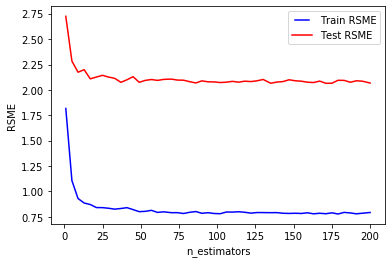

In [0]:
# Find N_ESTIMATORS
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 200, num=50)]
train_results = []
test_results = []
for estimator in n_estimators:
  rf = RandomForestRegressor(n_estimators=estimator, n_jobs=-1)
  rf.fit(X_train, y_train)
  train_pred = rf.predict(X_train)
  train_results.append(np.sqrt(metrics.mean_squared_error(y_train, train_pred)))
  #train_results.append(rf.score(X_train, y_train))
  y_pred = rf.predict(X_test)
  test_results.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  #test_results.append(rf.score(X_test, y_test))

line1, = plt.plot(n_estimators, train_results, 'b', label='Train RSME')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test RSME')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RSME')
plt.xlabel('n_estimators')
plt.show()

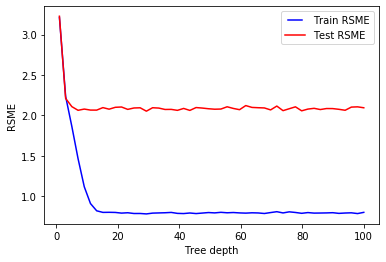

In [0]:
# Find MAX_DEPTH
max_depths = np.linspace(start = 1, stop = 100, num=50, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
  rf = RandomForestRegressor(max_depth=max_depth, n_jobs=-1)
  rf.fit(X_train, y_train)
  train_pred = rf.predict(X_train)
  train_results.append(np.sqrt(metrics.mean_squared_error(y_train, train_pred)))
  #train_results.append(rf.score(X_train, y_train))
  y_pred = rf.predict(X_test)
  test_results.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  #test_results.append(rf.score(X_test, y_test))

line1, = plt.plot(max_depths, train_results, 'b', label='Train RSME')
line2, = plt.plot(max_depths, test_results, 'r', label='Test RSME')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RSME')
plt.xlabel('Tree depth')
plt.show()

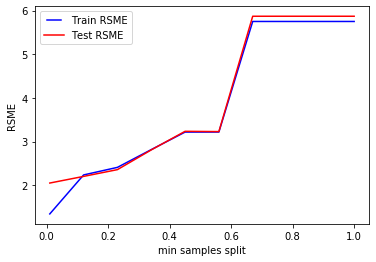

In [0]:
# Find MIN_SAMPLES_SPLIT
min_samples_splits = np.linspace(start = 0.01, stop = 1.0, num=10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
  rf = RandomForestRegressor(min_samples_split=min_samples_split)
  rf.fit(X_train, y_train)
  train_pred = rf.predict(X_train)
  train_results.append(np.sqrt(metrics.mean_squared_error(y_train, train_pred)))
  #train_results.append(rf.score(X_train, y_train))
  y_pred = rf.predict(X_test)
  test_results.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  #test_results.append(rf.score(X_test, y_test))

line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train RSME')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test RSME')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RSME')
plt.xlabel('min samples split')
plt.show()

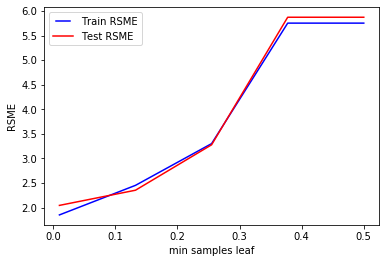

In [0]:
# Find MIN_SAMPLES_LEAF
min_samples_leafs = np.linspace(start = 0.01, stop = 0.5, num=5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
  rf = RandomForestRegressor(min_samples_leaf=min_samples_leaf)
  rf.fit(X_train, y_train)
  train_pred = rf.predict(X_train)
  train_results.append(np.sqrt(metrics.mean_squared_error(y_train, train_pred)))
  #train_results.append(rf.score(X_train, y_train))
  y_pred = rf.predict(X_test)
  test_results.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  #test_results.append(rf.score(X_test, y_test))

line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train RSME')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test RSME')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RSME')
plt.xlabel('min samples leaf')
plt.show()

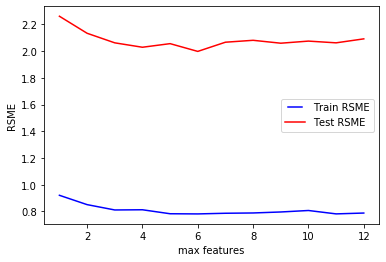

In [0]:
# Find MAX_FEATURES
max_features = list(range(1,X.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
  rf = RandomForestRegressor(max_features=max_feature)
  rf.fit(X_train, y_train)
  train_pred = rf.predict(X_train)
  train_results.append(np.sqrt(metrics.mean_squared_error(y_train, train_pred)))
  #train_results.append(rf.score(X_train, y_train))
  y_pred = rf.predict(X_test)
  test_results.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  #test_results.append(rf.score(X_test, y_test))

line1, = plt.plot(max_features, train_results, 'b', label='Train RSME')
line2, = plt.plot(max_features, test_results, 'r', label='Test RSME')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RSME')
plt.xlabel('max features')
plt.show()

#### Find the best combination of params

**TRY ALL PARAMS TO FIND THE BEST PARAMS FOR OUR DATA**

Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try.

In [0]:
#@title Default title text
def searchBestParamsForRF(params, train_features, train_labels):
  # First create the base model to tune
  rf = RandomForestRegressor()
  # Instantiate the grid search model
  grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = 5, n_jobs = -1, verbose = 2)
  # Fit the grid search to the data
  grid_search.fit(train_features, train_labels)
  print(f"The best estimator had RMSE {np.sqrt(-grid_search.best_score_)} and the following parameters:")
  print(grid_search.best_params_)

# Create the parameter grid
max_depth = [int(x) for x in np.linspace(10, 20, num = 3)]
max_depth.append(None)
param_grid = {
    'bootstrap': [False, True],
    'n_estimators': [int(x) for x in np.linspace(start = 40, stop = 60, num = 4)],
    'max_depth': max_depth,
    'min_samples_split': [float(x) for x in np.linspace(0.1, 0.2, num = 2)],
    'min_samples_leaf': [float(x) for x in np.linspace(0.1, 0.2, num = 2)],
    'max_features': [X.shape[1]]
}

# Comment or Uncomment this line to seach for the best params
searchBestParamsForRF(param_grid, X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   16.1s


The best estimator had RMSE 2.4193712927593256 and the following parameters:
{'bootstrap': True, 'max_depth': 10, 'max_features': 13, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 46}


[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:   27.0s finished


### Train and evaluate model

In [0]:
m = RandomForestRegressor(n_estimators=60, max_features=X.shape[1])
m.fit(X_train, y_train)

evaluate(m, X_train, y_train, X_test, y_test)



# MODEL PERFORMANCE
# Train set
# | Mean Absolute Error: 0.5758625862586259
# | Mean Square Error: 0.6365449044904491
# | Root Mean Square Error: 0.7978376429389936
# | Train Score: 0.9807615052050999
# Test set
# | Mean Absolute Error: 1.5209793351302785
# | Mean Square Error: 4.284529050613956
# | Root Mean Square Error: 2.0699103967597137
# | Test Score: 0.8757254225805797
# | Explained Variance: 0.8758109846903823

MODEL PERFORMANCE
Train set
| Mean Absolute Error: 0.5777677767776779
| Mean Square Error: 0.6461221122112212
| Root Mean Square Error: 0.8038172131842047
| Train Score: 0.9804720502749198
Test set
| Mean Absolute Error: 1.5185534591194971
| Mean Square Error: 4.309985774183887
| Root Mean Square Error: 2.076050523032589
| Test Score: 0.8749870395455335
| Explained Variance: 0.8750061249382027


In [0]:
X_test.tail()

,year,month,dayofweek,hour,holiday,football,basketball,temperature,humidity,wind,cloud,available_prev,available
660,2020,1,6,10,0,0,0,11.571833,70.500000,0.933333,0.000000,0,1
1111,2020,1,4,5,0,0,0,8.962167,93.816667,1.828333,63.333333,1,1
590,2020,1,3,12,0,0,0,12.725667,64.000000,0.500000,20.000000,14,16
629,2020,1,5,3,0,1,0,6.119667,93.000000,2.583333,20.000000,14,14
1270,2020,1,3,20,0,0,0,15.654833,51.866667,6.245000,100.000000,19,19


In [0]:
y_test.tail()

660      5
1111     0
590     17
629     14
1270    18
Name: available_next, dtype: int64

In [0]:
m.predict([[2020, 1, 6, 10, 0, 0, 0, 11.57, 70.50, 0.93, 0, 0, 1]])

array([2.6])

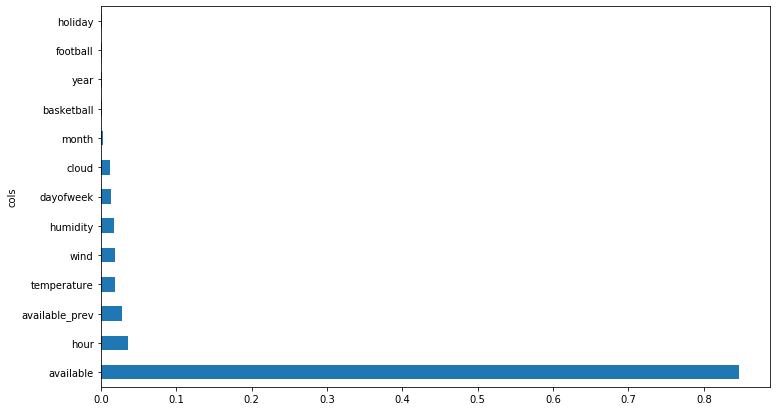

In [0]:
# Show the importance of each variable in prediction
def rf_feat_importance(m, df):
  return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)
  
fi = rf_feat_importance(m, X); 
fi[:].plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

# Download model

In [0]:
# Import package
import pickle

In [0]:
# Generate file
with open('model.pkl', 'wb') as model_file:
  pickle.dump(m, model_file)